### 1. Import Dependencies and Setup

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense ,Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model 

### 2. Load Data 

In [3]:
data_dir = "data/image"
classes = os.listdir(data_dir)
classes

['NORMAL', 'PNEUMONIA']

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 5232 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
images, labels = batch
images.shape, labels

((32, 256, 256, 3),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int32))

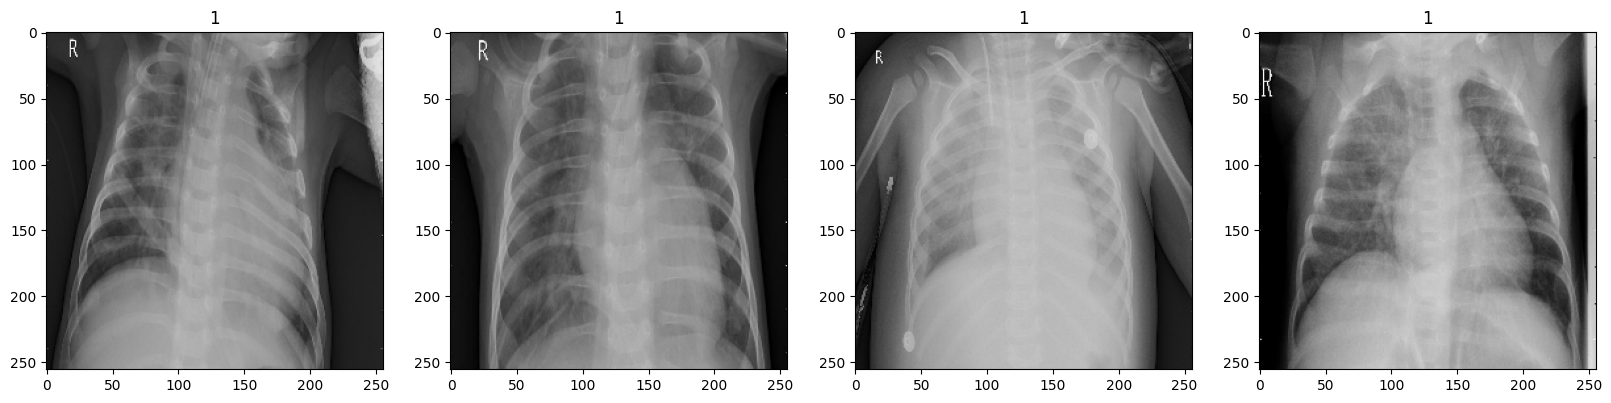

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
batch[0].min() ,batch[0].max()

(np.float32(0.0), np.float32(255.0))

### 3. Data Preprocessing & Scaling

In [8]:
scaled = batch[0] / 255.0
scaled.min(), scaled.max()

(np.float32(0.0), np.float32(1.0))

In [9]:
data = data.map(lambda x, y: (x / 255.0, y))

In [10]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
images, labels = batch
images.shape, labels

((32, 256, 256, 3),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32))

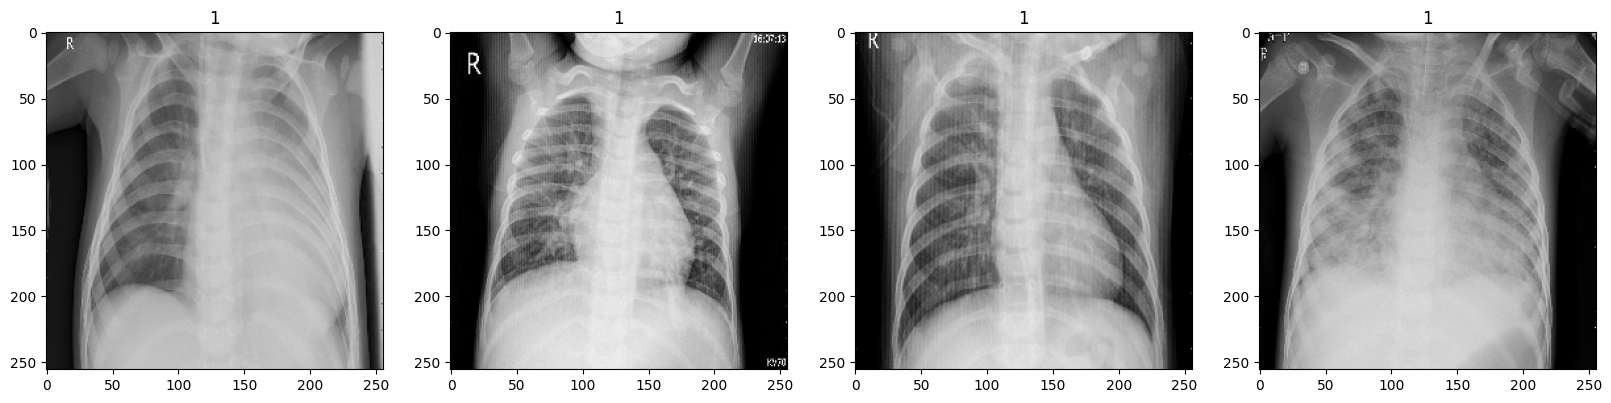

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 4. Splitting Data into Training, Valuating and Testing Sets

In [12]:
data_length = len(data) 

train_size = int(data_length * 0.7) # 128 * 32 = 4096
val_size = int(data_length * 0.2) # 36 * 32 = 1152
test_size = int(data_length * 0.1) # 18 * 32 = 576


print(data_length)
train_size, val_size, test_size

164


(114, 32, 16)

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### 5. Model Building

In [14]:
model = Sequential()

In [15]:
model.add(Input(shape=(256, 256, 3)))
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### 6. Model Training 

In [18]:
logs_dir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [19]:
history = model.fit(train, epochs=24, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 189ms/step - accuracy: 0.8323 - loss: 0.3960 - val_accuracy: 0.9521 - val_loss: 0.1317
Epoch 2/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.9586 - loss: 0.1012 - val_accuracy: 0.9600 - val_loss: 0.1113
Epoch 3/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.9785 - loss: 0.0638 - val_accuracy: 0.9541 - val_loss: 0.1441
Epoch 4/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9824 - loss: 0.0549 - val_accuracy: 0.9570 - val_loss: 0.1383
Epoch 5/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.9852 - loss: 0.0439 - val_accuracy: 0.9717 - val_loss: 0.0991
Epoch 6/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9881 - loss: 0.0418 - val_accuracy: 0.9688 - val_loss: 0.1122
Epoch 7/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9935 - loss: 0.0222 - val_accuracy: 0.9609 - val_loss: 0.1380
Epoch 8/24
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.9945 - loss: 0

### 7. Plot Performance

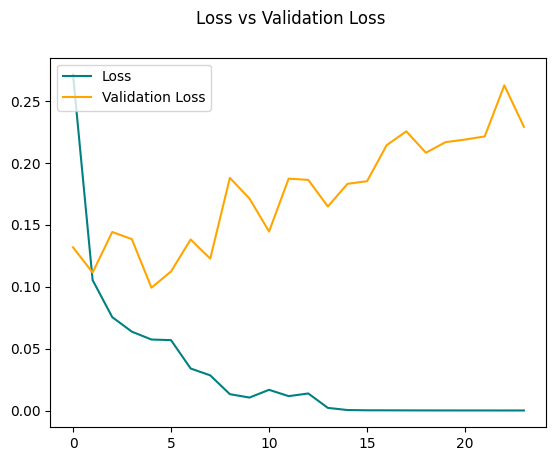

In [20]:
accuracy, val_accuracy = history.history['loss'], history.history['val_loss']

fig = plt.figure()
plt.plot(accuracy, color = 'teal', label='Loss')
plt.plot(val_accuracy, color = 'orange', label='Validation Loss')
fig.suptitle('Loss vs Validation Loss')
plt.legend(loc='upper left')
plt.show()

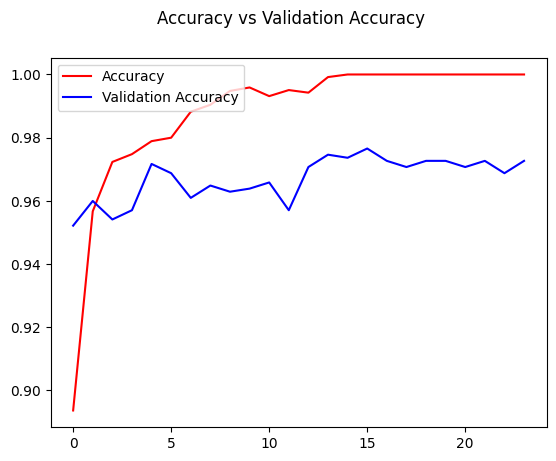

In [21]:
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

fig = plt.figure()
plt.plot(accuracy, color = 'red', label='Accuracy')
plt.plot(val_accuracy, color = 'blue', label='Validation Accuracy')
fig.suptitle('Accuracy vs Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

### 8. Model Evaluation

In [22]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [23]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [24]:
print('Precision: ', pre.result().numpy())
print('Recall: ', rec.result().numpy())
print('Accuracy: ', acc.result().numpy())

Precision:  0.9892761
Recall:  0.984
Accuracy:  0.98046875


### 9. Testing Model

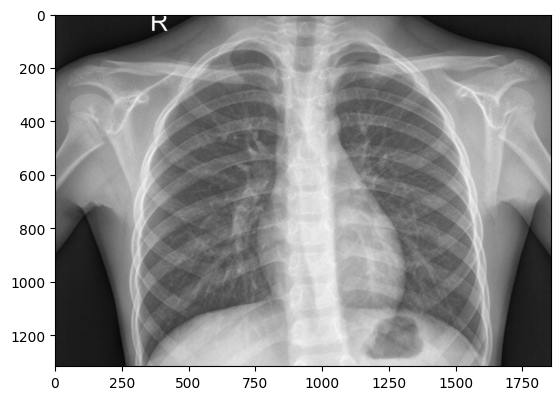

In [28]:
img = cv2.imread('data/image/test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(img)
plt.show()

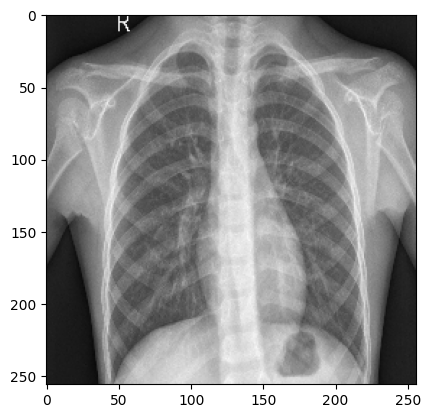

In [29]:
resized = cv2.resize(img, (256, 256))
plt.imshow(resized)
plt.show()

In [30]:
yhat = model.predict(np.array([resized / 255.0]))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([[8.536244e-06]], dtype=float32)

In [31]:
if yhat > 0.5:
    print('Pneumonia')
else:
    print('Normal')

Normal


In [34]:
def predict(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (256, 256))
    yhat = model.predict(np.array([resized / 255.0]), verbose=False)
    if yhat > 0.5:
        print('Pneumonia')
    else:
        print('Normal')

predict('data/image/test/NORMAL/IM-0001-0001.jpeg')
predict('data/image/test/PNEUMONIA/person1_virus_6.jpeg')  

Normal
Pneumonia


### 10. Save Model 

In [35]:
model.save('models/main_model.keras')

In [36]:
new_model = load_model('models/main_model.keras')

In [38]:
def predict(img_path):
    img = cv2.imread(img_path)
    resized = cv2.resize(img, (256, 256))
    yhat = new_model.predict(np.array([resized / 255.0]), verbose=False)
    if yhat > 0.5:
        return 'Pneumonia'
    return 'Normal'

predict('data/image/test/NORMAL/IM-0001-0001.jpeg'), predict('data/image/test/PNEUMONIA/person1_virus_6.jpeg')

('Normal', 'Pneumonia')